In [ ]:
!pip install --upgrade tensorflow
!pip install git+https://github.com/ahmedfgad/Mask-RCNN-TF2.git
# Clone the Matterport Mask R-CNN repository and install it
!git clone https://github.com/matterport/Mask_RCNN.git
!pip install -r Mask_RCNN/requirements.txt
!pip install Mask_RCNN/

In [ ]:
!git clone https://github.com/experiencor/raccoon_dataset.git
!ls raccoon_dataset/data
!ls raccoon_dataset/images
!ls raccoon_dataset/labels
!ls raccoon_dataset/annotations

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

In [4]:
!pip install --upgrade tensorflow

In [5]:
from fastai.vision.all import *
from fastcore.utils import *
from pathlib import Path
import re
from fastcore.utils import L

In [6]:
import kagglehub

path = kagglehub.dataset_download("devdgohil/the-oxfordiiit-pet-dataset")

print("Path to dataset files:", path)


100%|██████████| 780M/780M [00:36<00:00, 22.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2


In [7]:
from pathlib import Path

base_dir = Path("/root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2")
image_dir = base_dir / "images" / "images"
annotation_dir = base_dir / "annotations" / "annotations"


In [8]:
import os

# Define paths based on your dataset location
base_dir = "/root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2"
image_dir = os.path.join(base_dir, "images", "images")
annotation_dir = os.path.join(base_dir, "annotations", "annotations")

# List contents of each directory
print("\nBase Directory Contents:")
print(os.listdir(base_dir)[:10])  # List a few files in the base directory

print("\nImage Directory Contents:")
print(os.listdir(image_dir)[:10])  # List a few files in the image directory

print("\nAnnotation Directory Contents:")
print(os.listdir(annotation_dir)[:10])  # List a few files in the annotation directory



Base Directory Contents:
['images', 'annotations']

Image Directory Contents:
['havanese_56.jpg', 'keeshond_168.jpg', 'german_shorthaired_168.jpg', 'american_bulldog_57.jpg', 'miniature_pinscher_197.jpg', 'Ragdoll_115.jpg', 'Siamese_109.jpg', 'beagle_187.jpg', 'german_shorthaired_114.jpg', 'newfoundland_20.jpg']

Annotation Directory Contents:
['README', 'xmls', 'list.txt', 'test.txt', '._trimaps', 'trainval.txt', 'trimaps']


In [9]:
# Path to list.txt file
list_txt_path = os.path.join(annotation_dir, "list.txt")

# Display the first few lines to understand its structure
with open(list_txt_path, "r") as file:
    lines = file.readlines()[:10]  # Read first 10 lines for inspection
    for line in lines:
        print(line.strip())


#Image CLASS-ID SPECIES BREED ID
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Cat 1:12:Dog
#All images with 1st letter as captial are cat images
#images with small first letter are dog images
Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1


In [10]:
columns = ["filename", "class_id", "species", "breed_id"]
data = pd.read_csv(list_txt_path, sep=" ", names=columns, comment="#")


print(data.head())


         filename  class_id  species  breed_id
0  Abyssinian_100         1        1         1
1  Abyssinian_101         1        1         1
2  Abyssinian_102         1        1         1
3  Abyssinian_103         1        1         1
4  Abyssinian_104         1        1         1


In [11]:
# Set the image directory path relative to the base directory
base_dir = "/root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2"
image_dir = os.path.join(base_dir, "images", "images")

# Check the contents of the image directory to verify filenames and extensions
print("Sample files in image directory:", os.listdir(image_dir)[:10])


Sample files in image directory: ['havanese_56.jpg', 'keeshond_168.jpg', 'german_shorthaired_168.jpg', 'american_bulldog_57.jpg', 'miniature_pinscher_197.jpg', 'Ragdoll_115.jpg', 'Siamese_109.jpg', 'beagle_187.jpg', 'german_shorthaired_114.jpg', 'newfoundland_20.jpg']


Sample Metadata:
Filename: Abyssinian_100
Class ID: 1
Species: 1
Breed ID: 1


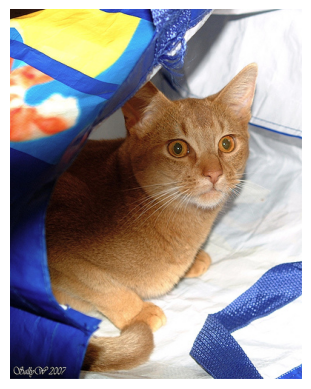

In [12]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Convert image filenames to the full path using the confirmed directory
data['image_path'] = data['filename'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))  # Adjust extension if needed

# Select a sample row to display
sample = data.iloc[0]
print(f"Sample Metadata:\nFilename: {sample['filename']}\nClass ID: {sample['class_id']}\nSpecies: {sample['species']}\nBreed ID: {sample['breed_id']}")

# Open the sample image and display it using matplotlib
sample_image = Image.open(sample['image_path'])
plt.imshow(sample_image)
plt.axis("off")  # Hide axes for a cleaner view
plt.show()


In [13]:
import tensorflow as tf

def read_and_preprocess(filename, label):
    # Load the image
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128))

    # Convert image to float32 type and normalize to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image, label


In [14]:
# Convert filenames and labels to a tf dataset
file_paths = data['image_path'].values
labels = data['class_id'].values

# Create a tf dataset from file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

dataset = dataset.map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)


In [15]:
def read_and_preprocess(data):
    # Resize the image and mask to 128x128
    input_image = tf.image.resize(data['image'], (128, 128))
    input_mask = tf.image.resize(data['segmentation_mask'], (128, 128))

    # Convert image to float32 type and normalize to [0, 1]
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)

    # Adjust the mask values from {1,2,3} to {0,1,2} by subtracting 1
    input_mask -= 1

    return input_image, input_mask

In [16]:
from sklearn.model_selection import train_test_split

# Split file paths and labels into training and testing sets
train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42
)


In [17]:
# Display the number of samples in each split
print(f"Number of training samples: {len(train_file_paths)}")
print(f"Number of testing samples: {len(test_file_paths)}\n")

# Display a few samples from the training set
print("Sample training data:")
for i in range(5):
    print(f"File path: {train_file_paths[i]} - Label: {train_labels[i]}")

# Display a few samples from the testing set
print("\nSample testing data:")
for i in range(5):
    print(f"File path: {test_file_paths[i]} - Label: {test_labels[i]}")


Number of training samples: 5879
Number of testing samples: 1470

Sample training data:
File path: /root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2/images/images/american_bulldog_107.jpg - Label: 2
File path: /root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2/images/images/keeshond_178.jpg - Label: 19
File path: /root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2/images/images/Maine_Coon_72.jpg - Label: 21
File path: /root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2/images/images/chihuahua_126.jpg - Label: 11
File path: /root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2/images/images/staffordshire_bull_terrier_25.jpg - Label: 35

Sample testing data:
File path: /root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2/images/images/keeshond_164.jpg - Label: 19
File path: /root/.cache/kagglehub/datasets/devdgohil/the-oxf

In [18]:
# b) Create the segmentation mask
# Show some images from dataset and their segmented version

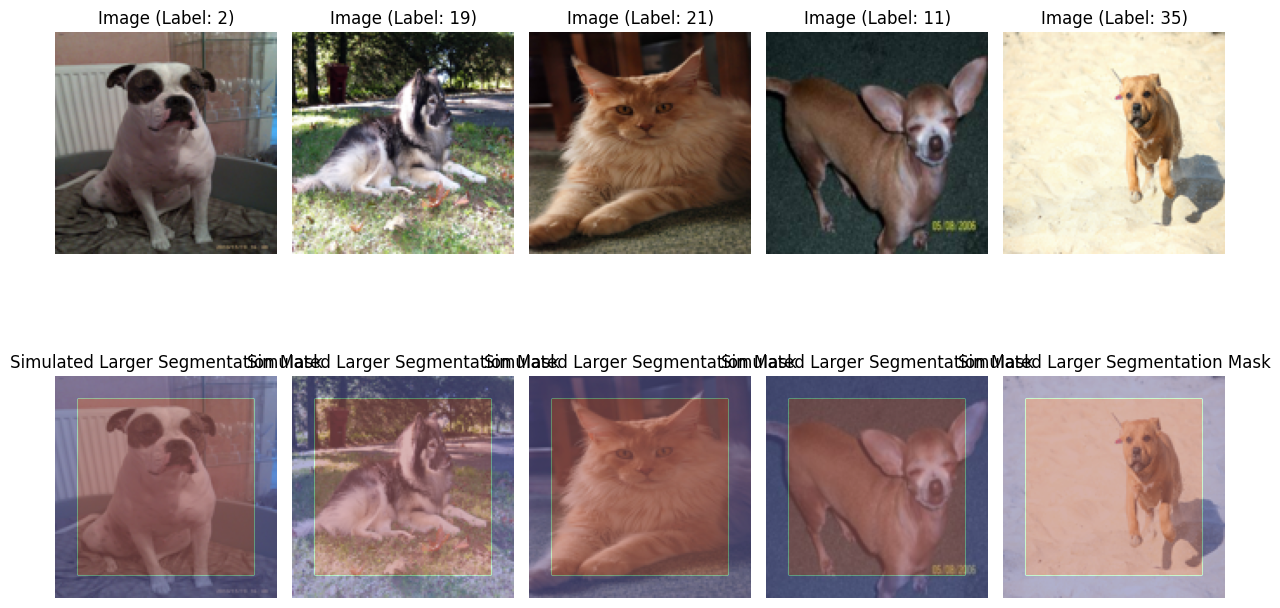

In [19]:
import numpy as np
import cv2

def create_larger_centered_mask(image_shape, class_label):
    """
    Creates a simulated segmentation mask with a larger area, covering around 70-80% of the image,
    centered on the animal, assuming it is located near the center.
    """
    height, width = image_shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    # Define the size of the central rectangle mask, covering around 70% of the image
    center_height = int(height * 0.8)
    center_width = int(width * 0.8)

    # Define the start and end points of the mask
    top_left_y = (height - center_height) // 2
    top_left_x = (width - center_width) // 2
    bottom_right_y = top_left_y + center_height
    bottom_right_x = top_left_x + center_width

    # Apply the class label to this central area
    mask[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = class_label

    return mask

# Displaying the mask with improved visualization
def display_images_with_larger_masks(file_paths, labels, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        # Load the image and resize it to 128x128
        image_path = file_paths[i]
        image = Image.open(image_path).resize((128, 128))
        image_np = np.array(image)

        # Generate a larger centered segmentation mask based on the class label
        mask = create_larger_centered_mask(image_np.shape, labels[i])

        # Plot the original image
        ax = plt.subplot(2, num_samples, i + 1)
        plt.imshow(image_np)
        plt.title(f"Image (Label: {labels[i]})")
        plt.axis("off")

        # Plot the mask overlay
        ax = plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(image_np, alpha=0.7)
        plt.imshow(mask, cmap='jet', alpha=0.3)  # Overlay the mask
        plt.title("Simulated Larger Segmentation Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display a few samples from the training set with larger masks
display_images_with_larger_masks(train_file_paths, train_labels)


**Part 2- Annotation**

In [20]:
# Get data from here https://github.com/experiencor/raccoon_dataset


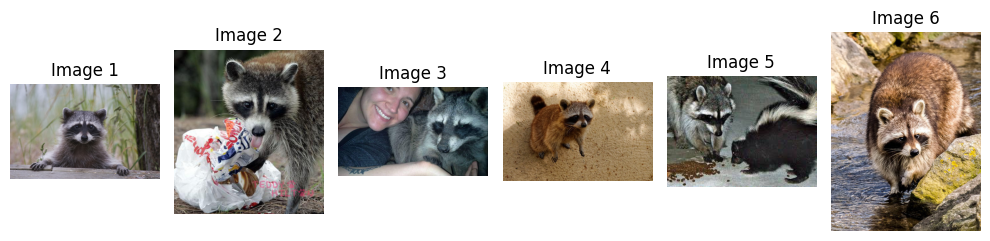

In [21]:
import matplotlib.pyplot as plt
import cv2
import os

# Function to display 6 sample images from the dataset
def plot_raccoon_images(num_samples=6):
    plt.figure(figsize=(10, 10))

    # Directory containing the images
    image_dir = 'raccoon_dataset/images'

    # Get a list of sample images
    images = sorted([img for img in os.listdir(image_dir) if img.endswith('.jpg')])[:num_samples]

    for i, image_name in enumerate(images):
        # Load and display 6 images
        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path)

        # Check if image loading was successful
        if image is None:
            print(f"Error loading image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert color for displaying with Matplotlib

        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        plt.axis("off")

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()  # Explicitly display the plot

plot_raccoon_images()

In [22]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

# class that defines and loads the raccoon dataset
class RaccoonDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("raccoon_dataset", 1, "raccoon")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotations/raccoon-'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[8:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		#path = '/content/raccoon_dataset/annotations/raccoon-'+image_id   #Added by me
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('raccoon'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = RaccoonDataset()
train_set.load_dataset('raccoon_dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = RaccoonDataset()
test_set.load_dataset('raccoon_dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 149
Test: 51


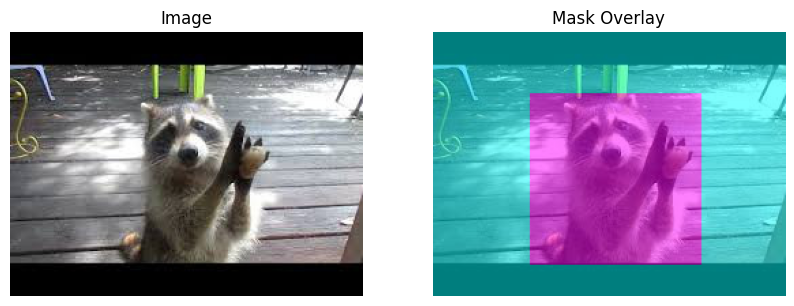

In [23]:
# load an image
# Use the function above to create the image and its mask

import random
import matplotlib.pyplot as plt
from mrcnn.config import Config

# Define a simple configuration for Mask R-CNN
class RaccoonConfig(Config):
    NAME = "raccoon_cfg"
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = RaccoonConfig()

# Select a random image ID from the training set
image_id = random.choice(train_set.image_ids)

# Now load the image and mask directly
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)

# And display the image and mask
plt.figure(figsize=(10, 5))

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")
plt.axis("off")

# Overlay each mask channel on the image with a cool color
plt.subplot(1, 2, 2)
plt.imshow(image)
for i in range(mask.shape[-1]):
    plt.imshow(mask[:, :, i], cmap="cool", alpha=0.5)
plt.title("Mask Overlay")
plt.axis("off")

plt.show()


**Part 3- YOLO**




You can see how YOLO has been improved in the last few versions on COCO: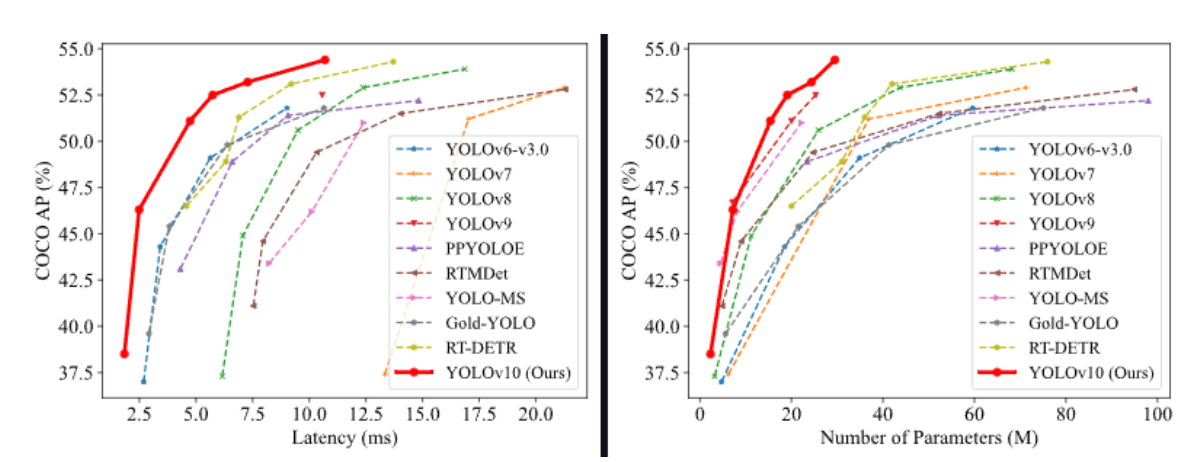

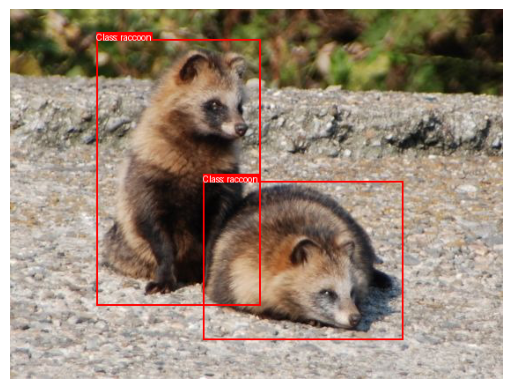

In [24]:
# a- Create annotation
# You can upload the file using ![title](filename.jpeg)
# import image module
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os

def display_image_with_annotation(image_path, annotation_path):

    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # Parse the XML annotation file
    if os.path.exists(annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Iterate over all objects in the annotation
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

            label_text = f"Class: {class_name}"

            # Use textbox to calculate text size
            text_bbox = draw.textbbox((0, 0), label_text)
            text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
            text_x = max(xmin, 0)
            text_y = max(ymin - text_height, 0)

      # Draw background rectangle for the text label
            draw.rectangle([text_x, text_y, text_x + text_width, text_y + text_height], fill="red")
            draw.text((text_x, text_y), label_text, fill="white")

    # Correctly display with annotations
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Path to file/Image 72
image_path = 'raccoon_dataset/images/raccoon-72.jpg'
annotation_path = 'raccoon_dataset/annotations/raccoon-72.xml'

# Display the image with annotations
display_image_with_annotation(image_path, annotation_path)



In [25]:
#b- Download required tools
# Install the required packages.
import os
HOME = os.getcwd()
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [26]:
# Load pretrained weights
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


In [27]:

# Confirm existance of directory
import os

dirs = [
    "raccoon_dataset/images/train",
    "raccoon_dataset/images/test",
    "raccoon_dataset/labels/train",
    "raccoon_dataset/labels/test"
]

#this will make sure the directory exists and make one if it doesnt
for dir_path in dirs:
    os.makedirs(dir_path, exist_ok=True)
    print(f"Verified directory: {dir_path}")

# Function to list files in a directory
def list_files_in_dir(directory):
    if os.path.exists(directory):
        files = os.listdir(directory)
        if files:
            print(f"Files in '{directory}': {files[:5]}... (and {len(files) - 5} more)" if len(files) > 5 else f"Files in '{directory}': {files}")
        else:
            print(f"No files found in '{directory}'.")
    else:
        print(f"Directory '{directory}' does not exist.")

# List contents of each directory
print("\nChecking directory contents:\n")
for dir_path in dirs:
    list_files_in_dir(dir_path)


Verified directory: raccoon_dataset/images/train
Verified directory: raccoon_dataset/images/test
Verified directory: raccoon_dataset/labels/train
Verified directory: raccoon_dataset/labels/test

Checking directory contents:

No files found in 'raccoon_dataset/images/train'.
No files found in 'raccoon_dataset/images/test'.
No files found in 'raccoon_dataset/labels/train'.
No files found in 'raccoon_dataset/labels/test'.


In [28]:
import shutil

# Define where all images are located
source_images_dir = "raccoon_dataset/images"

# Move images to train and test folders keeping in mind the split
for filename in os.listdir(source_images_dir):
    if filename.endswith(".jpg"):
        # Extract the image ID
        image_id = int(filename.split('-')[-1].split('.')[0])

        # Decide destination based on ID
        if image_id < 150:
            dest_dir = "raccoon_dataset/images/train"
        else:
            dest_dir = "raccoon_dataset/images/test"

        # Move!
        shutil.move(os.path.join(source_images_dir, filename), os.path.join(dest_dir, filename))

print("Images moved to train and test directories based on the split.")


Images moved to train and test directories based on the split.


In [29]:
print("\nChecking directory contents:\n")
for dir_path in dirs:
    list_files_in_dir(dir_path)


Checking directory contents:

Files in 'raccoon_dataset/images/train': ['raccoon-137.jpg', 'raccoon-117.jpg', 'raccoon-130.jpg', 'raccoon-18.jpg', 'raccoon-143.jpg']... (and 144 more)
Files in 'raccoon_dataset/images/test': ['raccoon-173.jpg', 'raccoon-188.jpg', 'raccoon-200.jpg', 'raccoon-187.jpg', 'raccoon-172.jpg']... (and 46 more)
No files found in 'raccoon_dataset/labels/train'.
No files found in 'raccoon_dataset/labels/test'.


In [30]:
import xml.etree.ElementTree as ET

# Define paths for annotation files and label output directories
annotations_dir = 'raccoon_dataset/annotations'
train_labels_dir = 'raccoon_dataset/labels/train'
test_labels_dir = 'raccoon_dataset/labels/test'

#We've done all this code before I need to do it again for labels!


os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)


def convert_to_yolo_format(box, img_width, img_height):
    x_center = ((box[0] + box[2]) / 2) / img_width
    y_center = ((box[1] + box[3]) / 2) / img_height
    width = (box[2] - box[0]) / img_width
    height = (box[3] - box[1]) / img_height
    return f"0 {x_center} {y_center} {width} {height}"

# Loop through each annotation file and convert it
for filename in os.listdir(annotations_dir):
    if filename.endswith(".xml"):
        image_id = filename.split('-')[-1].split('.')[0]
        annotation_path = os.path.join(annotations_dir, filename)

      #extract bounding box
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        img_width = int(root.find('.//size/width').text)
        img_height = int(root.find('.//size/height').text)

        # Convert to YOLO format
        yolo_boxes = []
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            box = [xmin, ymin, xmax, ymax]
            yolo_boxes.append(convert_to_yolo_format(box, img_width, img_height))


        if int(image_id) < 150:
            label_path = os.path.join(train_labels_dir, f"{image_id}.txt")
        else:
            label_path = os.path.join(test_labels_dir, f"{image_id}.txt")

        with open(label_path, 'w') as f:
            f.write("\n".join(yolo_boxes))

print("Labels generated and placed in the correct directories.")


Labels generated and placed in the correct directories.


In [31]:
print("\nChecking directory contents:\n")
for dir_path in dirs:
    list_files_in_dir(dir_path)


Checking directory contents:

Files in 'raccoon_dataset/images/train': ['raccoon-137.jpg', 'raccoon-117.jpg', 'raccoon-130.jpg', 'raccoon-18.jpg', 'raccoon-143.jpg']... (and 144 more)
Files in 'raccoon_dataset/images/test': ['raccoon-173.jpg', 'raccoon-188.jpg', 'raccoon-200.jpg', 'raccoon-187.jpg', 'raccoon-172.jpg']... (and 46 more)
Files in 'raccoon_dataset/labels/train': ['12.txt', '122.txt', '79.txt', '43.txt', '71.txt']... (and 144 more)
Files in 'raccoon_dataset/labels/test': ['154.txt', '166.txt', '168.txt', '199.txt', '197.txt']... (and 46 more)


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")



image 1/1 /content/raccoon_dataset/images/test/raccoon-187.jpg: 640x640 1 cat, 10.7ms
Speed: 11.3ms preprocess, 10.7ms inference, 429.8ms postprocess per image at shape (1, 3, 640, 640)


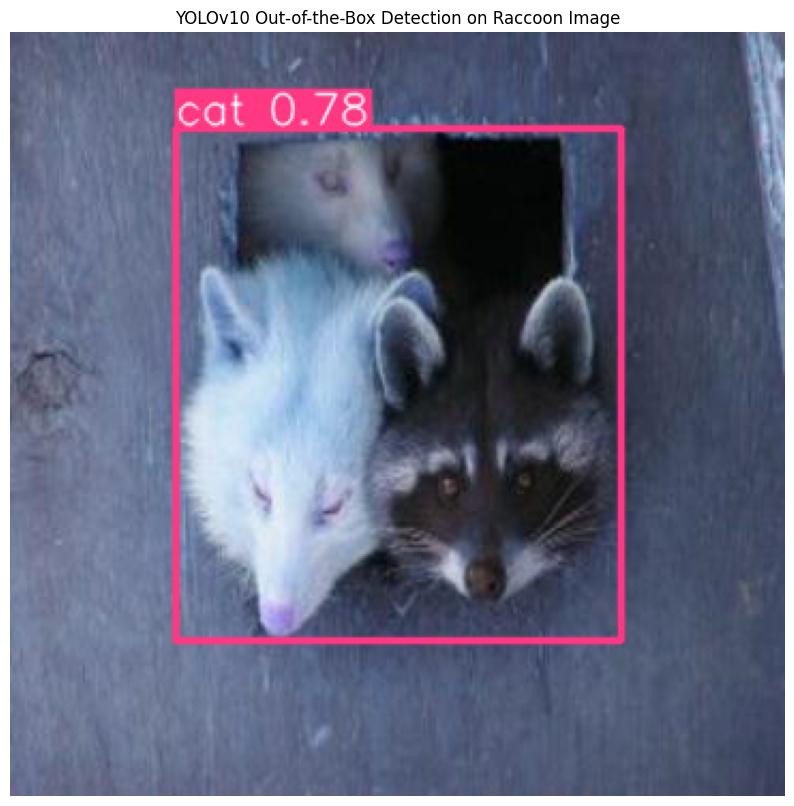

In [32]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained YOLOv10 model
model = YOLO("/content/weights/yolov10n.pt")  # nano = speed!

# Choose test image 187
test_image_path = "raccoon_dataset/images/test/raccoon-187.jpg"

# Perform inference on the test image
results = model(test_image_path)

# Extract the first result and use .plot() to get the image with annotations
output_image = results[0].plot()

plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis("off")
plt.title("YOLOv10 Out-of-the-Box Detection on Raccoon Image")
plt.show()


In [33]:
#d- Fine-tune the model
# Show the learning curve and confusion matrix


In [34]:
# Move the raccoon_dataset to /content/datasets
!mkdir -p /content/datasets
!mv raccoon_dataset /content/datasets/

In [36]:
# Confirming weights are in the right directory
!ls -lh /content/weights

total 408M
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


In [37]:
import os

# Paths to label directories
train_labels_dir = '/content/datasets/raccoon_dataset/labels/train'
test_labels_dir = '/content/datasets/raccoon_dataset/labels/test'

def inspect_labels(label_dir, num_files=5):
    label_files = os.listdir(label_dir)[:num_files]
    print(f"\nInspecting {num_files} label files in {label_dir}:\n")

    for label_file in label_files:
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            print(f"Contents of {label_file}:")
            print(f.read())
            print("-" * 40)

inspect_labels(train_labels_dir)
inspect_labels(test_labels_dir)



Inspecting 5 label files in /content/datasets/raccoon_dataset/labels/train:

Contents of 12.txt:
0 0.2972972972972973 0.520618556701031 0.3783783783783784 0.8247422680412371
0 0.6177606177606177 0.5824742268041238 0.5791505791505791 0.8247422680412371
----------------------------------------
Contents of 122.txt:
0 0.5084269662921348 0.3621908127208481 0.9382022471910112 0.6749116607773852
----------------------------------------
Contents of 79.txt:
0 0.5375 0.5011764705882353 0.7 0.9976470588235294
----------------------------------------
Contents of 43.txt:
0 0.25 0.5291666666666667 0.49583333333333335 0.6972222222222222
----------------------------------------
Contents of 71.txt:
0 0.59140625 0.49765258215962443 0.7796875 0.755868544600939
----------------------------------------

Inspecting 5 label files in /content/datasets/raccoon_dataset/labels/test:

Contents of 154.txt:
0 0.5115384615384615 0.4797136038186158 0.5676923076923077 0.6921241050119332
------------------------------

In [49]:
import os
import shutil

base_dir = "/content/datasets/raccoon_dataset"
train_images_dir = os.path.join(base_dir, "train/images")
train_labels_dir = os.path.join(base_dir, "train/labels")
test_images_dir = os.path.join(base_dir, "test/images")
test_labels_dir = os.path.join(base_dir, "test/labels")

# Create directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

# Move training images and labels
for img_file in os.listdir(f"{base_dir}/images/train"):
    shutil.move(f"{base_dir}/images/train/{img_file}", f"{train_images_dir}/{img_file}")

for label_file in os.listdir(f"{base_dir}/labels/train"):
    shutil.move(f"{base_dir}/labels/train/{label_file}", f"{train_labels_dir}/{label_file}")

# Move testing images and labels
for img_file in os.listdir(f"{base_dir}/images/test"):
    shutil.move(f"{base_dir}/images/test/{img_file}", f"{test_images_dir}/{img_file}")

for label_file in os.listdir(f"{base_dir}/labels/test"):
    shutil.move(f"{base_dir}/labels/test/{label_file}", f"{test_labels_dir}/{label_file}")

print("Files organized into combined directories for training and testing.")


Files organized into combined directories for training and testing.


In [50]:
data_yaml_content = """
path: /content/datasets/raccoon_dataset
train: train/images
val: test/images
nc: 1
names: ['raccoon']
"""

with open("/content/datasets/raccoon_dataset/data.yaml", "w") as f:
    f.write(data_yaml_content)

print("Updated data.yaml file with simplified paths.")


Updated data.yaml file with simplified paths.


In [51]:
import os

def check_image_label_pairs(images_dir, labels_dir):
    images = set(os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith(".jpg"))
    labels = set(os.path.splitext(f)[0] for f in os.listdir(labels_dir) if f.endswith(".txt"))
    missing_labels = images - labels
    extra_labels = labels - images
    return missing_labels, extra_labels

train_missing_labels, train_extra_labels = check_image_label_pairs(
    "/content/datasets/raccoon_dataset/train/images",
    "/content/datasets/raccoon_dataset/train/labels"
)

test_missing_labels, test_extra_labels = check_image_label_pairs(
    "/content/datasets/raccoon_dataset/test/images",
    "/content/datasets/raccoon_dataset/test/labels"
)

print("Training set:")
print("Missing labels for images:", train_missing_labels)
print("Extra labels without images:", train_extra_labels)

print("Testing set:")
print("Missing labels for images:", test_missing_labels)
print("Extra labels without images:", test_extra_labels)


Training set:
Missing labels for images: {'raccoon-44', 'raccoon-37', 'raccoon-108', 'raccoon-50', 'raccoon-120', 'raccoon-5', 'raccoon-4', 'raccoon-145', 'raccoon-15', 'raccoon-82', 'raccoon-96', 'raccoon-24', 'raccoon-57', 'raccoon-92', 'raccoon-90', 'raccoon-18', 'raccoon-79', 'raccoon-103', 'raccoon-53', 'raccoon-117', 'raccoon-112', 'raccoon-142', 'raccoon-13', 'raccoon-41', 'raccoon-11', 'raccoon-65', 'raccoon-22', 'raccoon-118', 'raccoon-89', 'raccoon-107', 'raccoon-121', 'raccoon-136', 'raccoon-134', 'raccoon-28', 'raccoon-131', 'raccoon-141', 'raccoon-52', 'raccoon-17', 'raccoon-75', 'raccoon-33', 'raccoon-138', 'raccoon-31', 'raccoon-51', 'raccoon-10', 'raccoon-69', 'raccoon-46', 'raccoon-35', 'raccoon-64', 'raccoon-119', 'raccoon-110', 'raccoon-80', 'raccoon-100', 'raccoon-137', 'raccoon-26', 'raccoon-60', 'raccoon-29', 'raccoon-25', 'raccoon-43', 'raccoon-14', 'raccoon-47', 'raccoon-115', 'raccoon-71', 'raccoon-98', 'raccoon-123', 'raccoon-143', 'raccoon-84', 'raccoon-36', 

In [52]:
from ultralytics import YOLO

model = YOLO("yolov10n.pt")

# Train the model
results = model.train(
    data="/content/datasets/raccoon_dataset/data.yaml",
    epochs=10,
    batch=16,
    imgsz=640,
    project="raccoon_yolo_project",
    name="raccoon_yolov8_training",
    verbose=True
)

print("Training completed.")


New https://pypi.org/project/ultralytics/8.3.29 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/datasets/raccoon_dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=raccoon_yolo_project, name=raccoon_yolov8_training4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False

train: Scanning /content/datasets/raccoon_dataset/train/labels.cache... 0 images, 149 backgrounds, 0 corrupt: 100%|██████████| 149/149 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/datasets/raccoon_dataset/train/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:205: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
val: Scanning /content/datasets/raccoon_dataset/test/labels.cache... 0 images, 51 backgrounds, 0 corrupt: 100%|██████████| 51/51 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/datasets/raccoon_dataset/test/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


Plotting labels to raccoon_yolo_project/raccoon_yolov8_training4/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to raccoon_yolo_project/raccoon_yolov8_training4
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:205: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/10      3.44G          0      120.2          0          0      119.4          0          0        640: 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         51          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/10      3.13G          0      112.9          0          0      113.7          0          0        640: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         51          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



wandb: WARNING Tried to log to step 1 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me


      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/10      3.14G          0      101.3          0          0        104          0          0        640: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         51          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/10      3.14G          0      91.97          0          0      95.43          0          0        640: 100%|██████████| 10/10 [00:01<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         51          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/10      3.14G          0      86.59          0          0      88.85          0          0        640: 100%|██████████| 10/10 [00:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         51          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/10      3.11G          0      86.88          0          0      89.07          0          0        640:  70%|███████   | 7/10 [00:01<00:00,  5.41it/s]wandb: WARNING Tried to log to step 2 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WAR

                   all         51          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/10      3.14G          0      76.56          0          0      78.34          0          0        640: 100%|██████████| 10/10 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         51          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/10      3.14G          0      73.33          0          0      74.84          0          0        640: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         51          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/10      3.14G          0      71.24          0          0      72.56          0          0        640: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         51          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



wandb: WARNING Tried to log to step 6 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me


      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/10      3.14G          0      69.68          0          0      70.95          0          0        640: 100%|██████████| 10/10 [00:01<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         51          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



10 epochs completed in 0.019 hours.
Optimizer stripped from raccoon_yolo_project/raccoon_yolov8_training4/weights/last.pt, 5.7MB
Optimizer stripped from raccoon_yolo_project/raccoon_yolov8_training4/weights/best.pt, 5.7MB

Validating raccoon_yolo_project/raccoon_yolov8_training4/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

                   all         51          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


Speed: 0.2ms preprocess, 5.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to raccoon_yolo_project/raccoon_yolov8_training4


AttributeError: 'DetMetrics' object has no attribute 'curves_results'. See valid attributes below.

    This class is a utility class for computing detection metrics such as precision, recall, and mean average precision
    (mAP) of an object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (tuple of str): A tuple of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (tuple of str): A tuple of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    

In [55]:
!apt-get update
!apt-get update
!apt-get install texlive-xetex texlive-fonts-recommended texlive-latex-extra
!jupyter nbconvert --to pdf 'AnovaYoungers_Assignment3.ipynb'

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRel